<h1>Imports</h1>

In [11]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
from collections import defaultdict

<h1>Flicker30k</h1>

--- Dataset Paths ---
Base Path:      /kaggle/input/flickr30k
Image Folder:   /kaggle/input/flickr30k/flickr30k_images
Captions File:  /kaggle/input/flickr30k/captions.txt

--- Loading Captions ---
Successfully loaded 158916 total caption entries.
Processed captions for 31784 unique images.

--- Preparing Image Paths ---
Mapped paths for 31783 images.

--- Key Dataset Details ---
- Total Caption Entries: 158916
- Number of Unique Images: 31784
- Number of Classes: Not applicable (Flickr30k is for image captioning, not classification with fixed classes). Captions describe scenes freely.
- Train/Val/Test Splits:
  - No standard train/val/test split files (e.g., train.txt) found in the dataset root.
  - You may need to create splits manually if required.

--- Displaying 3 Random Samples ---

Sample 1/3:
- Image File: 7746984692.jpg
- Path: /kaggle/input/flickr30k/flickr30k_images/7746984692.jpg
- Captions:
  0: A lone man heads off on a high mountain trail wearing a bright red jacket  bla

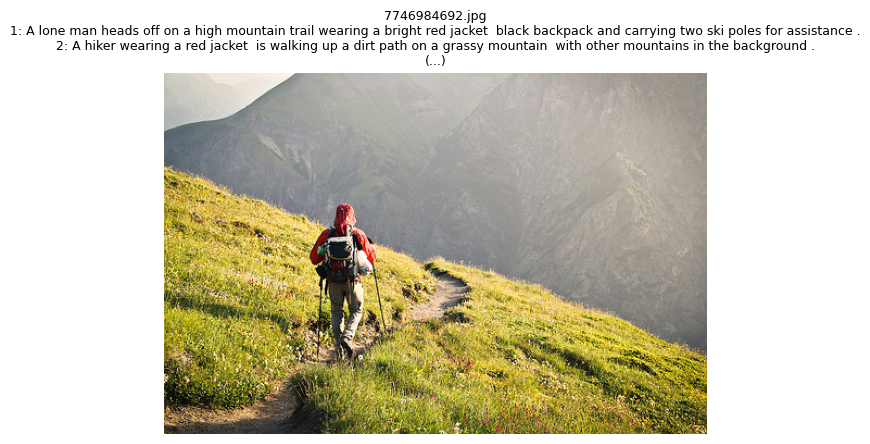


Sample 2/3:
- Image File: 3143982558.jpg
- Path: /kaggle/input/flickr30k/flickr30k_images/3143982558.jpg
- Captions:
  0: A woman in a red shirt is holding a black dog on a brown sofa with a little girl wearing a striped onsie with a pacifier in her mouth .
  1: A baby with a pink outfit on has a pacifier  and she is on a chair with another woman .
  2: A baby in pink  striped clothing is sitting near an older lady wearing red and black .
  3: The baby sitting next to the black dog is sucking a pacifier .
  4: A baby sitting next to a very old woman .


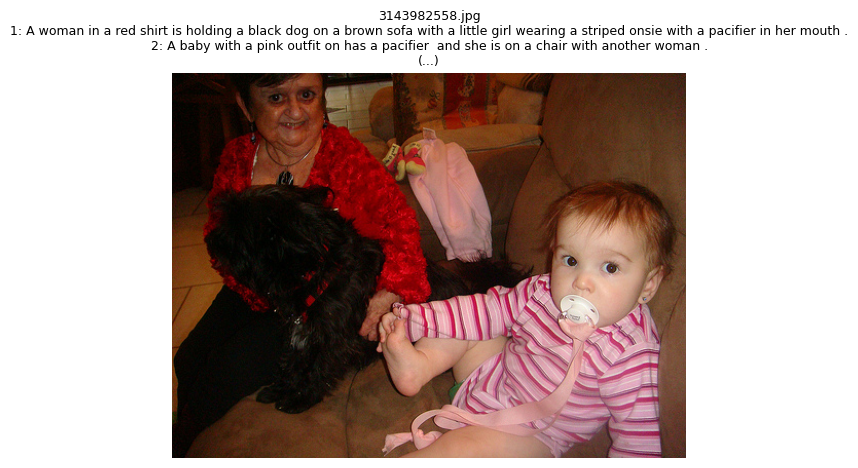


Sample 3/3:
- Image File: 3844515314.jpg
- Path: /kaggle/input/flickr30k/flickr30k_images/3844515314.jpg
- Captions:
  0: A man in a white striped shirt at a gambling table  is next to a woman in a black top  shuffling a pack of red cards .
  1: A man shuffling cards over a black counter with keys and some poker chips on it .
  2: A man with a white dress shirt shuffles cards next to a lady in a brown shirt .
  3: A man shuffling cards at a game being played with poker chips .
  4: A young male shuffles a deck of cards .


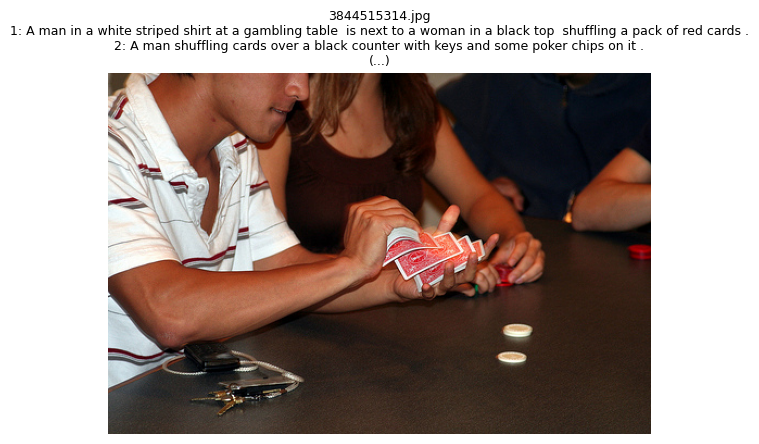

In [10]:
base_path = '/kaggle/input/flickr30k'
image_folder_name = 'flickr30k_images'
captions_file_name = 'captions.txt'
num_samples_to_show = 3 # How many random samples to display

# --- Paths ---
image_folder = os.path.join(base_path, image_folder_name)
captions_file = os.path.join(base_path, captions_file_name)

print("--- Dataset Paths ---")
print(f"Base Path:      {base_path}")
print(f"Image Folder:   {image_folder}")
print(f"Captions File:  {captions_file}")

# --- Data Loading ---
df_captions = None
captions_dict = {}
image_paths = {}
split_counts = {}

# Load Captions
try:
    print("\n--- Loading Captions ---")
    if not os.path.exists(captions_file):
         raise FileNotFoundError(f"Captions file not found at {captions_file}")

    df_captions = pd.read_csv(
        captions_file,
        delimiter=',',
        header=None,
        names=['image_name', 'caption_index', 'caption']
    )
    # Clean captions
    df_captions['caption'] = df_captions['caption'].astype(str).str.strip()
    print(f"Successfully loaded {len(df_captions)} total caption entries.")

    # Process into dictionary (Image Name -> List of Captions)
    captions_dict = df_captions.groupby('image_name')['caption'].apply(list).to_dict()
    print(f"Processed captions for {len(captions_dict)} unique images.")

except FileNotFoundError as e:
    print(f"ERROR: {e}")
except Exception as e:
    print(f"ERROR: An error occurred loading or processing captions: {e}")

# Prepare Image Paths
if captions_dict:
    print("\n--- Preparing Image Paths ---")
    if not os.path.isdir(image_folder):
         print(f"ERROR: Image folder not found at {image_folder}. Cannot map images.")
    else:
        missing_images = 0
        for img_name in captions_dict.keys():
            full_path = os.path.join(image_folder, img_name)
            if os.path.exists(full_path): 
                 image_paths[img_name] = full_path
            else:
                 # print(f"Warning: Image file not found for caption entry: {full_path}")
                 missing_images += 1
        print(f"Mapped paths for {len(image_paths)} images.")
        if missing_images > 0:
             print(f"Warning: Could not find image files for {missing_images} entries listed in captions file.")


# --- Dataset Details ---
print("\n--- Key Dataset Details ---")
if df_captions is not None:
    print(f"- Total Caption Entries: {len(df_captions)}")
else:
    print("- Total Caption Entries: Could not load captions.")

if captions_dict:
    print(f"- Number of Unique Images: {len(captions_dict)}")
    print("- Number of Classes: Not applicable (Flickr30k is for image captioning, not classification with fixed classes). Captions describe scenes freely.")
else:
    print("- Number of Unique Images: Could not process captions.")
    print("- Number of Classes: Not applicable.")

# Check for Train/Val/Test Splits (Common convention, might not exist in this specific Kaggle dataset)
print("- Train/Val/Test Splits:")
split_files_to_check = {
    'Train': ['train.txt', 'train_images.txt'],
    'Validation': ['val.txt', 'validation.txt', 'val_images.txt'],
    'Test': ['test.txt', 'test_images.txt']
}
found_any_split = False
for split_name, possible_fnames in split_files_to_check.items():
    found_current_split = False
    for fname in possible_fnames:
        fpath = os.path.join(base_path, fname)
        if os.path.exists(fpath):
            try:
                with open(fpath, 'r') as f:
                    split_image_names = [line.strip() for line in f if line.strip()]
                count = len(split_image_names)
                split_counts[split_name] = count
                print(f"  - {split_name}: Found '{fname}' with {count} images.")
                found_any_split = True
                found_current_split = True
                break 
            except Exception as e:
                print(f"  - {split_name}: Found '{fname}' but error reading: {e}")

if not found_any_split:
    print("  - No standard train/val/test split files (e.g., train.txt) found in the dataset root.")
    print("  - You may need to create splits manually if required.")


# --- Display Samples ---
print(f"\n--- Displaying {num_samples_to_show} Random Samples ---")
if captions_dict and image_paths:
    available_image_names = list(image_paths.keys())
    if len(available_image_names) == 0:
        print("No images with valid paths available to display samples.")
    else:
        num_samples_actual = min(num_samples_to_show, len(available_image_names))
        if num_samples_actual < num_samples_to_show:
             print(f"Warning: Only {num_samples_actual} images with paths found, showing that many.")

        # Get random samples from the *available* images
        sample_image_names = random.sample(available_image_names, num_samples_actual)

        for i, img_name in enumerate(sample_image_names):
            img_path = image_paths[img_name]
            img_captions = captions_dict[img_name]

            print(f"\nSample {i+1}/{num_samples_actual}:")
            print(f"- Image File: {img_name}")
            print(f"- Path: {img_path}")
            print("- Captions:")
            for cap_idx, cap_text in enumerate(img_captions):
                print(f"  {cap_idx}: {cap_text}")

            try:
                img = Image.open(img_path)
                plt.figure(figsize=(7, 5))
                plt.imshow(img)
                # Create a concise title
                title = f"{img_name}\n1: {img_captions[0]}"
                if len(img_captions) > 1:
                     title += f"\n2: {img_captions[1]}"
                if len(img_captions) > 2:
                     title += "\n(...)"

                plt.title(title, fontsize=9)
                plt.axis('off')
                plt.show()

            except FileNotFoundError:
                print(f"  ERROR: Image file not found at the expected path: {img_path}")
            except Exception as e:
                print(f"  ERROR: Could not load or display image {img_name}: {e}")

elif not captions_dict:
     print("Cannot display samples because captions could not be loaded/processed.")
elif not image_paths:
     print("Cannot display samples because no valid image paths were prepared.")

<h1>PascalVoc2009</h1>

--- Dataset Paths ---
Base VOC Path:      /kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/
Image Directory:    /kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/JPEGImages
Annotation Dir:   /kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/Annotations
ImageSet Main Dir: /kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/ImageSets/Main

--- Loading Annotations & Gathering Info ---
Found 7818 annotation files. Parsing...
Finished parsing annotations.

--- Key Dataset Details ---
- Total Images (.jpg): 7818
- Total Annotations (.xml): 7818
- Total Object Instances Annotated: 21544
- Number of Unique Classes: 20
- Unique Classes: aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor
- Train/Val/Test Splits (from ImageSets/Main):
  - Train: Found 'train.txt' with 3473 images.
  - Val: Found 'val.txt' with 3581 images.
  - Trainval: Found 'trainval.txt' with 7054 images.

--- Displaying 2 Random Samples ---


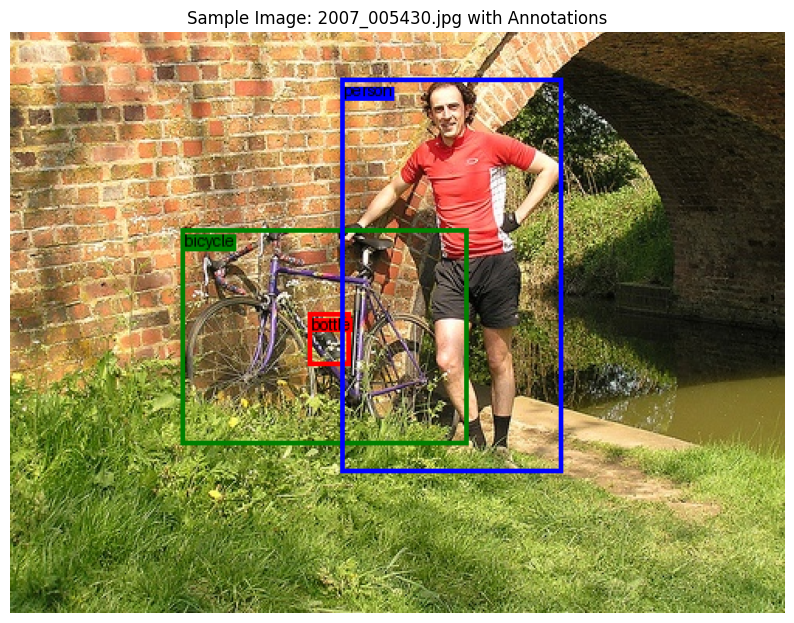


Sample 2/2:
- Annotation: /kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/Annotations/2008_004985.xml
- Image:      /kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/JPEGImages/2008_004985.jpg
- Found 2 objects:
  - Class: chair, BBox: [174, 197, 225, 277]
  - Class: chair, BBox: [194, 226, 249, 310]
Default fonts (DejaVuSans, Arial) not found, using load_default(). Text quality might be lower.


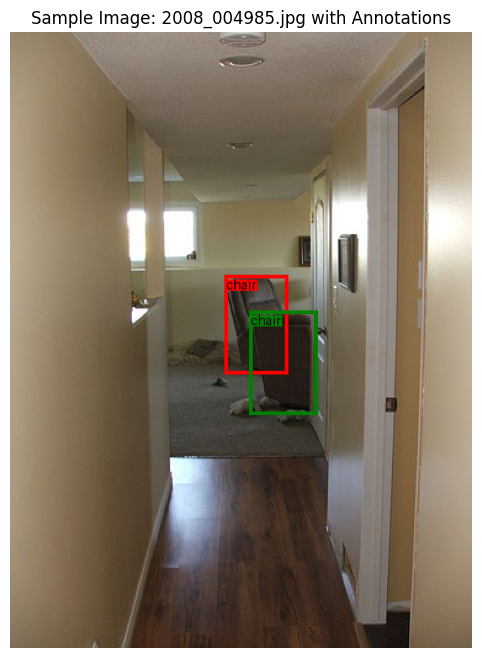

In [12]:
base_voc_path = '/kaggle/input/pascalvoc2009/VOCdevkit/VOC2009/'
num_samples_to_show = 2

image_dir = os.path.join(base_voc_path, 'JPEGImages')
annotation_dir = os.path.join(base_voc_path, 'Annotations')
imageset_main_dir = os.path.join(base_voc_path, 'ImageSets', 'Main')

print("--- Dataset Paths ---")
print(f"Base VOC Path:      {base_voc_path}")
print(f"Image Directory:    {image_dir}")
print(f"Annotation Dir:   {annotation_dir}")
print(f"ImageSet Main Dir: {imageset_main_dir}")

all_image_files = []
all_annotation_files = []
unique_classes = set()
annotation_counts_per_image = {}
total_object_annotations = 0

if not os.path.isdir(image_dir):
     print(f"ERROR: Image directory not found at {image_dir}")
if not os.path.isdir(annotation_dir):
     print(f"ERROR: Annotation directory not found at {annotation_dir}")

try:
    print("\n--- Loading Annotations & Gathering Info ---")
    all_annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith('.xml')]
    if not all_annotation_files:
         print(f"ERROR: No annotation XML files found in {annotation_dir}")
    else:
        print(f"Found {len(all_annotation_files)} annotation files. Parsing...")
        for xml_file_name in all_annotation_files:
            xml_file_path = os.path.join(annotation_dir, xml_file_name)
            try:
                tree = ET.parse(xml_file_path)
                root = tree.getroot()
                objects_in_file = 0
                for obj in root.findall('object'):
                    class_name = obj.find('name').text
                    unique_classes.add(class_name)
                    objects_in_file += 1
                annotation_counts_per_image[xml_file_name] = objects_in_file
                total_object_annotations += objects_in_file
            except ET.ParseError as pe:
                print(f"Warning: Could not parse XML file {xml_file_name}: {pe}")
            except Exception as e:
                print(f"Warning: Error processing file {xml_file_name}: {e}")
        print("Finished parsing annotations.")

except FileNotFoundError:
     print(f"ERROR: Annotation directory not found at {annotation_dir}")
except Exception as e:
     print(f"An unexpected error occurred during annotation loading: {e}")

try:
     all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
except FileNotFoundError:
     print(f"ERROR: Image directory not found at {image_dir}")
except Exception as e:
     print(f"An unexpected error occurred listing image files: {e}")


print("\n--- Key Dataset Details ---")
print(f"- Total Images (.jpg): {len(all_image_files)}")
print(f"- Total Annotations (.xml): {len(all_annotation_files)}")
print(f"- Total Object Instances Annotated: {total_object_annotations}")

if unique_classes:
    sorted_classes = sorted(list(unique_classes))
    print(f"- Number of Unique Classes: {len(sorted_classes)}")
    print(f"- Unique Classes: {', '.join(sorted_classes)}")
else:
    print("- Number of Unique Classes: Could not determine (annotations failed?).")
    print("- Unique Classes: Could not determine.")

print("- Train/Val/Test Splits (from ImageSets/Main):")
split_counts = {}
expected_split_files = ['train.txt', 'val.txt', 'trainval.txt', 'test.txt']
found_any_split = False

if not os.path.isdir(imageset_main_dir):
    print(f"  - WARNING: ImageSets/Main directory not found at {imageset_main_dir}")
else:
    for fname in expected_split_files:
        fpath = os.path.join(imageset_main_dir, fname)
        if os.path.exists(fpath):
            try:
                with open(fpath, 'r') as f:
                    split_image_ids = [line.strip().split()[0] for line in f if line.strip()]
                count = len(split_image_ids)
                split_name = os.path.splitext(fname)[0].capitalize()
                split_counts[split_name] = count
                print(f"  - {split_name}: Found '{fname}' with {count} images.")
                found_any_split = True
            except Exception as e:
                print(f"  - {fname}: Found but error reading: {e}")

if not found_any_split:
     print("  - No standard split files (train.txt, val.txt, etc.) found in ImageSets/Main.")


def parse_voc_annotation(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            if xmin >= xmax or ymin >= ymax:
                 print(f"Warning: Invalid bbox coordinates in {xml_file} for object '{name}': [{xmin},{ymin},{xmax},{ymax}]")
                 continue
            objects.append({'name': name, 'bbox': [xmin, ymin, xmax, ymax]})
        return objects
    except ET.ParseError as pe:
        print(f"Error parsing XML file {xml_file}: {pe}")
        return []
    except Exception as e:
        print(f"Error processing XML file {xml_file}: {e}")
        return []

def draw_boxes(image_path, annotations):
    try:
        image = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(image)
        colors = ["red", "green", "blue", "yellow", "purple", "orange", "cyan", "magenta", "lime", "pink"]
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 15)
        except IOError:
             try:
                 font = ImageFont.truetype("arial.ttf", 15)
             except IOError:
                 print("Default fonts (DejaVuSans, Arial) not found, using load_default(). Text quality might be lower.")
                 font = ImageFont.load_default()

        for i, obj in enumerate(annotations):
            box = obj['bbox']
            label = obj['name']
            color = colors[i % len(colors)]
            draw.rectangle(box, outline=color, width=3)
            text_position = (box[0] + 2, box[1] + 2)
            text_bbox = draw.textbbox(text_position, label, font=font)
            draw.rectangle(text_bbox, fill=color)
            draw.text(text_position, label, fill="black", font=font)

        return image

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error drawing boxes: {e}")
        return None

print(f"\n--- Displaying {num_samples_to_show} Random Samples ---")
if not all_annotation_files:
    print("Cannot display samples because no annotation files were found.")
elif not all_image_files:
    print("Cannot display samples because no image files were found.")
else:
    num_samples_actual = min(num_samples_to_show, len(all_annotation_files))
    sample_xml_names = random.sample(all_annotation_files, num_samples_actual)

    for i, sample_xml_name in enumerate(sample_xml_names):
        print(f"\nSample {i+1}/{num_samples_actual}:")
        sample_xml_path = os.path.join(annotation_dir, sample_xml_name)
        base_name = os.path.splitext(sample_xml_name)[0]
        sample_image_name = base_name + '.jpg'
        sample_image_path = os.path.join(image_dir, sample_image_name)

        print(f"- Annotation: {sample_xml_path}")
        print(f"- Image:      {sample_image_path}")

        if not os.path.exists(sample_image_path):
             print(f"  ERROR: Corresponding image file not found!")
             continue

        annotations = parse_voc_annotation(sample_xml_path)
        if not annotations:
             print("  - No valid objects found or error parsing this annotation file.")
             continue

        print(f"- Found {len(annotations)} objects:")
        for ann in annotations:
             print(f"  - Class: {ann['name']}, BBox: {ann['bbox']}")

        image_with_boxes = draw_boxes(sample_image_path, annotations)

        if image_with_boxes:
            plt.figure(figsize=(10, 8))
            plt.imshow(image_with_boxes)
            plt.title(f"Sample Image: {sample_image_name} with Annotations")
            plt.axis('off')
            plt.show()
        else:
            print("  - Failed to draw boxes for this sample.")